In [67]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, transforms, gridspec
from scipy.optimize import fsolve
from collections import namedtuple
import ipywidgets as widgets  # interactive display
from ipywidgets import GridspecLayout, HBox, VBox, FloatSlider, Layout, ToggleButtons
from ipywidgets import interactive, interactive_output, Checkbox, Select

In [68]:
from matplotlib import colors

def plot_joint_probs(P, ):
    assert np.all(P >= 0), "probabilities should be >= 0"
    # normalize if not
    P = P / np.sum(P)
    marginal_y = np.sum(P,axis=1)
    marginal_x = np.sum(P,axis=0)

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005

    # start with a square Figure
    fig = plt.figure(figsize=(5, 5))

    joint_prob = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    rect_x_cmap = plt.cm.Blues
    rect_y_cmap = plt.cm.Reds

    # Show joint probs and marginals
    ax = fig.add_axes(joint_prob)
    ax_x = fig.add_axes(rect_histx, sharex=ax)
    ax_y = fig.add_axes(rect_histy, sharey=ax)

    # Show joint probs and marginals
    ax.matshow(P,vmin=0., vmax=1., cmap='Greys')
    ax_x.bar(0, marginal_x[0], facecolor=rect_x_cmap(marginal_x[0]))
    ax_x.bar(1, marginal_x[1], facecolor=rect_x_cmap(marginal_x[1]))
    ax_y.barh(0, marginal_y[0], facecolor=rect_y_cmap(marginal_y[0]))
    ax_y.barh(1, marginal_y[1], facecolor=rect_y_cmap(marginal_y[1]))
    # set limits
    ax_x.set_ylim([0, 1])
    ax_y.set_xlim([0, 1])

    # show values
    ind = np.arange(2)
    x,y = np.meshgrid(ind,ind)
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{P[i, j]:.2f}"
        ax.text(j,i, c, va='center', ha='center', color='black')
    for i in ind:
        v = marginal_x[i]
        c = f"{v:.2f}"
        ax_x.text(i, v +0.1, c, va='center', ha='center', color='black')
        v = marginal_y[i]
        c = f"{v:.2f}"
        ax_y.text(v+0.2, i, c, va='center', ha='center', color='black')

    # set up labels
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xticklabels(['Silver', 'Gold'])
    ax.set_yticklabels(['Small', 'Large'])
    ax.set_xlabel('color')
    ax.set_ylabel('size')
    ax_x.axis('off')
    ax_y.axis('off')
    return fig


def plot_prior_likelihood_posterior(prior, likelihood, posterior):
    # definitions for the axes
    left, width = 0.05, 0.3
    bottom, height = 0.05, 0.9
    padding = 0.12
    small_width = 0.1
    left_space = left + small_width + padding
    added_space = padding + width

    fig = plt.figure(figsize=(12, 4))

    rect_prior = [left, bottom, small_width, height]
    rect_likelihood = [left_space , bottom , width, height]
    rect_posterior = [left_space +  added_space, bottom , width, height]

    ax_prior = fig.add_axes(rect_prior)
    ax_likelihood = fig.add_axes(rect_likelihood, sharey=ax_prior)
    ax_posterior = fig.add_axes(rect_posterior, sharey = ax_prior)

    rect_colormap = plt.cm.Blues

    # Show posterior probs and marginals
    ax_prior.barh(0, prior[0], facecolor=rect_colormap(prior[0, 0]))
    ax_prior.barh(1, prior[1], facecolor=rect_colormap(prior[1, 0]))
    ax_likelihood.matshow(likelihood, vmin=0., vmax=1., cmap='Reds')
    ax_posterior.matshow(posterior, vmin=0., vmax=1., cmap='Greens')

    # Probabilities plot details
    ax_prior.set(xlim=[1, 0], xticks=[], yticks=[0, 1],
                 yticklabels=['left', 'right'], title="Prior p(s)")
    ax_prior.yaxis.tick_right()
    ax_prior.spines['left'].set_visible(False)
    ax_prior.spines['bottom'].set_visible(False)

    # Likelihood plot details
    ax_likelihood.set(xticks=[0, 1], xticklabels=['fish', 'no fish'],
                      yticks=[0, 1], yticklabels=['left', 'right'],
                      ylabel='state (s)', xlabel='measurement (m)',
                      title='Likelihood p(m (left) | s)')
    ax_likelihood.xaxis.set_ticks_position('bottom')
    ax_likelihood.spines['left'].set_visible(False)
    ax_likelihood.spines['bottom'].set_visible(False)

    # Posterior plot details
    ax_posterior.set(xticks=[0, 1], xticklabels=['fish', 'no fish'],
                     yticks=[0, 1], yticklabels=['left', 'right'],
                     ylabel='state (s)', xlabel='measurement (m)',
                     title='Posterior p(s | m)')
    ax_posterior.xaxis.set_ticks_position('bottom')
    ax_posterior.spines['left'].set_visible(False)
    ax_posterior.spines['bottom'].set_visible(False)

    # show values
    ind = np.arange(2)
    x,y = np.meshgrid(ind,ind)
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{posterior[i, j]:.2f}"
        ax_posterior.text(j, i, c, va='center', ha='center', color='black')
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{likelihood[i, j]:.2f}"
        ax_likelihood.text(j, i, c, va='center', ha='center', color='black')
    for i in ind:
        v = prior[i, 0]
        c = f"{v:.2f}"
        ax_prior.text(v+0.2, i, c, va='center', ha='center', color='black')


def plot_prior_likelihood(ps, p_a_s1, p_a_s0, measurement):
    likelihood = np.asarray([[p_a_s1, 1-p_a_s1], [p_a_s0, 1-p_a_s0]])
    assert 0.0 <= ps <= 1.0
    prior = np.asarray([ps, 1 - ps])
    if measurement == "Fish":
        posterior = likelihood[:, 0] * prior
    else:
        posterior = (likelihood[:, 1] * prior).reshape(-1)
    posterior /= np.sum(posterior)

    # definitions for the axes
    left, width = 0.05, 0.3
    bottom, height = 0.05, 0.9
    padding = 0.12
    small_width = 0.2
    left_space = left + small_width + padding
    small_padding = 0.05

    fig = plt.figure(figsize=(12, 4))

    rect_prior = [left, bottom, small_width, height]
    rect_likelihood = [left_space , bottom , width, height]
    rect_posterior = [left_space + width + small_padding, bottom , small_width, height]

    ax_prior = fig.add_axes(rect_prior)
    ax_likelihood = fig.add_axes(rect_likelihood, sharey=ax_prior)
    ax_posterior = fig.add_axes(rect_posterior, sharey=ax_prior)

    prior_colormap = plt.cm.Blues
    posterior_colormap = plt.cm.Greens

    # Show posterior probs and marginals
    ax_prior.barh(0, prior[0], facecolor=prior_colormap(prior[0]))
    ax_prior.barh(1, prior[1], facecolor=prior_colormap(prior[1]))
    ax_likelihood.matshow(likelihood, vmin=0., vmax=1., cmap='Reds')
    ax_posterior.barh(0, posterior[0], facecolor=posterior_colormap(posterior[0]))
    ax_posterior.barh(1, posterior[1], facecolor=posterior_colormap(posterior[1]))

    # Probabilities plot details
    ax_prior.set(xlim=[1, 0], yticks=[0, 1], yticklabels=['left', 'right'],
                 title="Prior p(s)", xticks=[])
    ax_prior.yaxis.tick_right()
    ax_prior.spines['left'].set_visible(False)
    ax_prior.spines['bottom'].set_visible(False)

    # Likelihood plot details
    ax_likelihood.set(xticks=[0, 1], xticklabels=['fish', 'no fish'],
                      yticks=[0, 1], yticklabels=['left', 'right'],
                      ylabel='state (s)', xlabel='measurement (m)',
                      title='Likelihood p(m | s)')
    ax_likelihood.xaxis.set_ticks_position('bottom')
    ax_likelihood.spines['left'].set_visible(False)
    ax_likelihood.spines['bottom'].set_visible(False)

    # Posterior plot details
    ax_posterior.set(xlim=[0, 1], xticks=[], yticks=[0, 1],
                     yticklabels=['left', 'right'],
                     title="Posterior p(s | m)")
    ax_posterior.spines['left'].set_visible(False)
    ax_posterior.spines['bottom'].set_visible(False)

    # show values
    ind = np.arange(2)
    x,y = np.meshgrid(ind, ind)
    for i in ind:
        v = posterior[i]
        c = f"{v:.2f}"
        ax_posterior.text(v+0.2, i, c, va='center', ha='center', color='black')
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{likelihood[i, j]:.2f}"
        ax_likelihood.text(j, i, c, va='center', ha='center', color='black')
    for i in ind:
        v = prior[i]
        c = f"{v:.2f}"
        ax_prior.text(v+0.2, i, c, va='center', ha='center', color='black')
    plt.show()
    return fig


def plot_utility(ps):
    prior = np.asarray([ps, 1 - ps])

    utility = np.array([[2, -3], [-2, 1]])

    expected = prior @ utility

    # definitions for the axes
    left, width = 0.05, 0.16
    bottom, height = 0.05, 0.9
    padding = 0.02
    small_width = 0.1
    left_space = left + small_width + padding
    added_space = padding + width

    fig = plt.figure(figsize=(17, 3))

    rect_prior = [left, bottom, small_width, height]
    rect_utility = [left + added_space , bottom , width, height]
    rect_expected = [left + 2* added_space, bottom , width, height]

    ax_prior = fig.add_axes(rect_prior)
    ax_utility = fig.add_axes(rect_utility, sharey=ax_prior)
    ax_expected = fig.add_axes(rect_expected)

    rect_colormap = plt.cm.Blues

    # Data of plots
    ax_prior.barh(0, prior[0], facecolor=rect_colormap(prior[0]))
    ax_prior.barh(1, prior[1], facecolor=rect_colormap(prior[1]))
    ax_utility.matshow(utility, cmap='cool')
    norm = colors.Normalize(vmin=-3, vmax=3)
    ax_expected.bar(0, expected[0], facecolor=rect_colormap(norm(expected[0])))
    ax_expected.bar(1, expected[1], facecolor=rect_colormap(norm(expected[1])))

    # Probabilities plot details
    ax_prior.set(xlim=[1, 0], xticks=[], yticks=[0, 1],
                 yticklabels=['left', 'right'], title="Probability of state")
    ax_prior.yaxis.tick_right()
    ax_prior.spines['left'].set_visible(False)
    ax_prior.spines['bottom'].set_visible(False)

    # Utility plot details
    ax_utility.set(xticks=[0, 1], xticklabels=['left', 'right'],
                   yticks=[0, 1], yticklabels=['left', 'right'],
                   ylabel='state (s)', xlabel='action (a)',
                   title='Utility')
    ax_utility.xaxis.set_ticks_position('bottom')
    ax_utility.spines['left'].set_visible(False)
    ax_utility.spines['bottom'].set_visible(False)

    # Expected utility plot details
    ax_expected.set(title='Expected utility', ylim=[-3, 3],
                    xticks=[0, 1], xticklabels=['left', 'right'],
                    xlabel='action (a)', yticks=[])
    ax_expected.xaxis.set_ticks_position('bottom')
    ax_expected.spines['left'].set_visible(False)
    ax_expected.spines['bottom'].set_visible(False)

    # show values
    ind = np.arange(2)
    x,y = np.meshgrid(ind,ind)

    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{utility[i, j]:.2f}"
        ax_utility.text(j, i, c, va='center', ha='center', color='black')
    for i in ind:
        v = prior[i]
        c = f"{v:.2f}"
        ax_prior.text(v+0.2, i, c, va='center', ha='center', color='black')
    for i in ind:
        v = expected[i]
        c = f"{v:.2f}"
        ax_expected.text(i, 2.5, c, va='center', ha='center', color='black')

    return fig


def plot_prior_likelihood_utility(ps, p_a_s1, p_a_s0, measurement):
    assert 0.0 <= ps <= 1.0
    assert 0.0 <= p_a_s1 <= 1.0
    assert 0.0 <= p_a_s0 <= 1.0
    prior = np.asarray([ps, 1 - ps])
    likelihood = np.asarray([[p_a_s1, 1-p_a_s1],[p_a_s0, 1-p_a_s0]])
    utility = np.array([[2.0, -3.0], [-2.0, 1.0]])

    if measurement == "Fish":
        posterior = likelihood[:, 0] * prior
    else:
        posterior = (likelihood[:, 1] * prior).reshape(-1)
    posterior /= np.sum(posterior)
    expected = posterior @ utility

    # definitions for the axes
    left, width = 0.05, 0.3
    bottom, height = 0.05, 0.3
    padding = 0.12
    small_width = 0.2
    left_space = left + small_width + padding
    small_padding = 0.05

    fig = plt.figure(figsize=(10, 9))

    rect_prior = [left, bottom + height + padding, small_width, height]
    rect_likelihood = [left_space , bottom + height + padding , width, height]
    rect_posterior = [left_space + width + small_padding,
                      bottom + height + padding,
                      small_width, height]

    rect_utility = [padding, bottom, width, height]
    rect_expected = [padding + width + padding + left, bottom, width, height]

    ax_likelihood = fig.add_axes(rect_likelihood)
    ax_prior = fig.add_axes(rect_prior, sharey=ax_likelihood)
    ax_posterior = fig.add_axes(rect_posterior, sharey=ax_likelihood)
    ax_utility = fig.add_axes(rect_utility)
    ax_expected = fig.add_axes(rect_expected)

    prior_colormap = plt.cm.Blues
    posterior_colormap = plt.cm.Greens
    expected_colormap = plt.cm.Wistia

    # Show posterior probs and marginals
    ax_prior.barh(0, prior[0], facecolor=prior_colormap(prior[0]))
    ax_prior.barh(1, prior[1], facecolor=prior_colormap(prior[1]))
    ax_likelihood.matshow(likelihood, vmin=0., vmax=1., cmap='Reds')
    ax_posterior.barh(0, posterior[0], facecolor=posterior_colormap(posterior[0]))
    ax_posterior.barh(1, posterior[1], facecolor=posterior_colormap(posterior[1]))
    ax_utility.matshow(utility, vmin=0., vmax=1., cmap='cool')
    ax_expected.bar(0, expected[0], facecolor=expected_colormap(expected[0]))
    ax_expected.bar(1, expected[1], facecolor=expected_colormap(expected[1]))

    # Probabilities plot details
    ax_prior.set(xlim=[1, 0], yticks=[0, 1], yticklabels=['left', 'right'],
                 title="Prior p(s)", xticks=[])
    ax_prior.yaxis.tick_right()
    ax_prior.spines['left'].set_visible(False)
    ax_prior.spines['bottom'].set_visible(False)

    # Likelihood plot details
    ax_likelihood.set(xticks=[0, 1], xticklabels=['fish', 'no fish'],
                      yticks=[0, 1], yticklabels=['left', 'right'],
                      ylabel='state (s)', xlabel='measurement (m)',
                      title='Likelihood p(m | s)')
    ax_likelihood.xaxis.set_ticks_position('bottom')
    ax_likelihood.spines['left'].set_visible(False)
    ax_likelihood.spines['bottom'].set_visible(False)

    # Posterior plot details
    ax_posterior.set(xlim=[0, 1], xticks=[], yticks=[0, 1],
                     yticklabels=['left', 'right'],
                     title="Posterior p(s | m)")
    ax_posterior.spines['left'].set_visible(False)
    ax_posterior.spines['bottom'].set_visible(False)

    # Utility plot details
    ax_utility.set(xticks=[0, 1], xticklabels=['left', 'right'],
                   xlabel='action (a)', yticks=[0, 1],
                   yticklabels=['left', 'right'],
                   title='Utility', ylabel='state (s)')
    ax_utility.xaxis.set_ticks_position('bottom')
    ax_utility.spines['left'].set_visible(False)
    ax_utility.spines['bottom'].set_visible(False)

    # Expected Utility plot details
    ax_expected.set(ylim=[-2, 2], xticks=[0, 1],
                    xticklabels=['left', 'right'],
                    xlabel='action (a)',
                    title='Expected utility', yticks=[])
    ax_expected.spines['left'].set_visible(False)

    # show values
    ind = np.arange(2)
    x,y = np.meshgrid(ind,ind)
    for i in ind:
        v = posterior[i]
        c = f"{v:.2f}"
        ax_posterior.text(v+0.2, i, c, va='center', ha='center', color='black')
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{likelihood[i,j]:.2f}"
        ax_likelihood.text(j, i, c, va='center', ha='center', color='black')
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{utility[i, j]:.2f}"
        ax_utility.text(j,i, c, va='center', ha='center', color='black')
    for i in ind:
        v = prior[i]
        c = f"{v:.2f}"
        ax_prior.text(v+0.2, i, c, va='center', ha='center', color='black')
    for i in ind:
        v = expected[i]
        c = f"{v:.2f}"
        ax_expected.text(i, v, c, va='center', ha='center', color='black')
    plt.show()
    return fig

In [69]:
def compute_marginal(px, py, cor):
    """ Calculate 2x2 joint probabilities given marginals p(x=1), p(y=1) and correlation
  
      Args:
        px (scalar): marginal probability of x
        py (scalar): marginal probability of y
        cor (scalar): correlation value
  
      Returns:
        ndarray of size (2, 2): joint probability array of x and y
    """

    p11 = px*py + cor*np.sqrt(px*py*(1-px)*(1-py))
    p01 = px - p11
    p10 = py - p11
    p00 = 1.0 - p11 - p01 - p10

    return np.asarray([[p00, p01], [p10, p11]])


def compute_cor_range(px,py):
    """ Calculate the allowed range of correlation values given marginals p(x=1)
      and p(y=1)
  
    Args:
      px (scalar): marginal probability of x
      py (scalar): marginal probability of y
  
    Returns:
      scalar, scalar: minimum and maximum possible values of correlation
    """

    def p11(corr):
        return px*py + corr*np.sqrt(px*py*(1-px)*(1-py))
    def p01(corr):
        return px - p11(corr)
    def p10(corr):
        return py - p11(corr)
    def p00(corr):
        return 1.0 - p11(corr) - p01(corr) - p10(corr)
    Cmax = min(fsolve(p01, 0.0), fsolve(p10, 0.0))
    Cmin = max(fsolve(p11, 0.0), fsolve(p00, 0.0))
    return Cmin, Cmax

In [70]:
# @markdown Execute this cell to use the widget
ps_widget = widgets.FloatSlider(0.9, description='p(s = left)',
                                min=0.0, max=1.0, step=0.01)

@widgets.interact(
    ps = ps_widget,
)
def make_utility_plot(ps):
    fig = plot_utility(ps)
    plt.show(fig)
    plt.close(fig)

interactive(children=(FloatSlider(value=0.9, description='p(s = left)', max=1.0, step=0.01), Output()), _dom_c…

In [71]:
style = {'description_width': 'initial'}
gs = GridspecLayout(2,2)

cor_widget = widgets.FloatSlider(0.0, description='ρ',
                                 min=-1, max=1, step=0.01)
px_widget = widgets.FloatSlider(0.5, description='p(color=golden)',
                                min=0.01, max=0.99, step=0.01,
                                style=style)
py_widget = widgets.FloatSlider(0.5, description='p(size=large)',
                                min=0.01, max=0.99, step=0.01,
                                style=style)
gs[0, 0] = cor_widget
gs[0, 1] = px_widget
gs[1, 0] = py_widget


@widgets.interact(
    px=px_widget,
    py=py_widget,
    cor=cor_widget,
)


def make_corr_plot(px, py, cor):
    Cmin, Cmax = compute_cor_range(px, py)  # allow correlation values
    cor_widget.min, cor_widget.max = Cmin+0.01, Cmax-0.01
    if cor_widget.value > Cmax:
        cor_widget.value = Cmax
    if cor_widget.value < Cmin:
        cor_widget.value = Cmin
    cor = cor_widget.value
    P = compute_marginal(px,py,cor)
    fig = plot_joint_probs(P)
    plt.show(fig)
    plt.close(fig)

interactive(children=(FloatSlider(value=0.5, description='p(color=golden)', layout=Layout(grid_area='widget002…

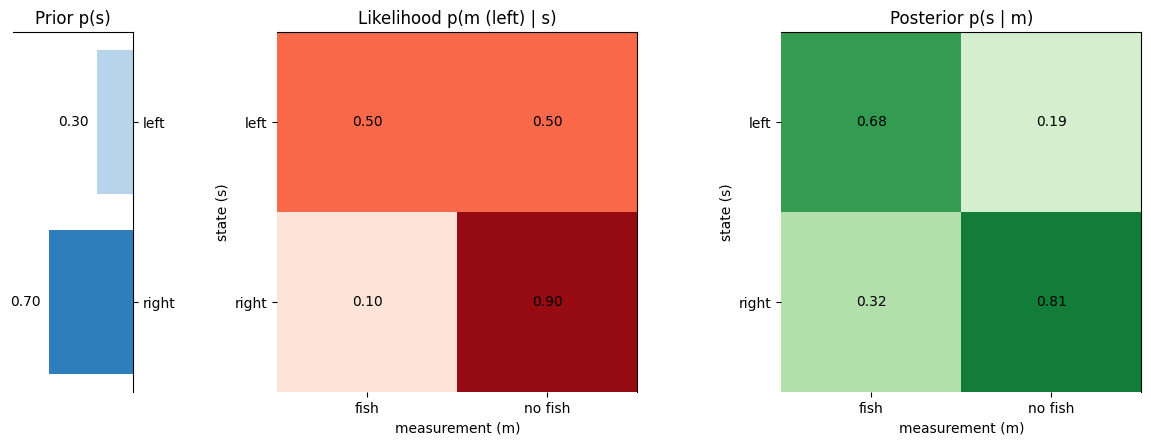

In [72]:
def compute_posterior(likelihood, prior):
    """ Use Bayes' Rule to compute posterior from likelihood and prior
  
    Args:
      likelihood (ndarray): i x j array with likelihood probabilities where i is
                      number of state options, j is number of measurement options
      prior (ndarray): i x 1 array with prior probability of each state
  
    Returns:
      ndarray: i x j array with posterior probabilities where i is
              number of state options, j is number of measurement options
  
    """

    # Compute unnormalized posterior (likelihood times prior)
    posterior = likelihood * prior

    # Compute p(m)
    p_m = np.sum(posterior, axis = 0)

    # Normalize posterior (divide elements by p_m)
    posterior /= p_m

    return posterior


# Make prior
prior = np.array([0.3, 0.7]).reshape((2, 1)) # first row is s = left, second row is s = right

# Make likelihood
likelihood = np.array([[0.5, 0.5], [0.1, 0.9]]) # first row is s = left, second row is s = right

# Compute posterior
posterior = compute_posterior(likelihood, prior)

# Visualize
plot_prior_likelihood_posterior(prior, likelihood, posterior)


In [73]:
# @markdown Execute this cell to enable the widget
# style = {'description_width': 'initial'}
ps_widget = widgets.FloatSlider(0.3, description='p(s = left)',
                                min=0.01, max=0.99, step=0.01)
p_a_s1_widget = widgets.FloatSlider(0.5,
                                    description='p(fish on left | state = left)',
                                    min=0.01, max=0.99, step=0.01, style=style,
                                    layout=Layout(width='370px'))
p_a_s0_widget = widgets.FloatSlider(0.1,
                                    description='p(fish on left | state = right)',
                                    min=0.01, max=0.99, step=0.01, style=style,
                                    layout=Layout(width='370px'))

observed_widget = ToggleButtons(options=['Fish', 'No Fish'],
                                description='Observation (m) on the left:', disabled=False, button_style='',
                                layout=Layout(width='auto', display="flex"),
                                style={'description_width': 'initial'}
                                )

widget_ui = VBox([ps_widget,
                  HBox([p_a_s1_widget, p_a_s0_widget]),
                  observed_widget])
widget_out = interactive_output(plot_prior_likelihood,
                                {'ps': ps_widget,
                                 'p_a_s1': p_a_s1_widget,
                                 'p_a_s0': p_a_s0_widget,
                                 'measurement': observed_widget})
display(widget_ui, widget_out)

Output()

In [74]:
ps_widget = widgets.FloatSlider(0.3, description='p(s = left)',
                                min=0.01, max=0.99, step=0.01,
                                layout=Layout(width='300px'))
p_a_s1_widget = widgets.FloatSlider(0.5,
                                    description='p(fish on left | state = left)',
                                    min=0.01, max=0.99, step=0.01,
                                    style=style, layout=Layout(width='370px'))
p_a_s0_widget = widgets.FloatSlider(0.1,
                                    description='p(fish on left | state = right)',
                                    min=0.01, max=0.99, step=0.01,
                                    style=style, layout=Layout(width='370px'))

observed_widget = ToggleButtons(options=['Fish', 'No Fish'],
                                description='Observation (m) on the left:', disabled=False, button_style='',
                                layout=Layout(width='auto', display="flex"),
                                style={'description_width': 'initial'}
                                )

widget_ui = VBox([ps_widget,
                  HBox([p_a_s1_widget, p_a_s0_widget]),
                  observed_widget])

widget_out = interactive_output(plot_prior_likelihood_utility,
                                {'ps': ps_widget,
                                 'p_a_s1': p_a_s1_widget,
                                 'p_a_s0': p_a_s0_widget,
                                 'measurement': observed_widget})
display(widget_ui, widget_out)

Output()

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import gamma as gamma_distribution
from matplotlib.transforms import Affine2D

In [76]:
import ipywidgets as widgets
from IPython.display import clear_output
from ipywidgets import FloatSlider, Dropdown, interactive_output
from ipywidgets import interact, fixed, HBox, Layout, VBox, interactive, Label

In [77]:
def plot_mixture_prior(x, gaussian1, gaussian2, combined):
    """ Plots a prior made of a mixture of gaussians
  
    Args:
      x (numpy array of floats):         points at which the likelihood has been evaluated
      gaussian1 (numpy array of floats): normalized probabilities for Gaussian 1 evaluated at each `x`
      gaussian2 (numpy array of floats): normalized probabilities for Gaussian 2 evaluated at each `x`
      posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`
  
    Returns:
      Nothing
    """
    fig, ax = plt.subplots()
    ax.plot(x, gaussian1, '--b', LineWidth=2, label='Gaussian 1')
    ax.plot(x, gaussian2, '-.b', LineWidth=2, label='Gaussian 2')
    ax.plot(x, combined, '-r', LineWidth=2, label='Gaussian Mixture')
    ax.legend()
    ax.set_ylabel('Probability')
    ax.set_xlabel('Orientation (Degrees)')


def plot_gaussian(mu, sigma):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    y = gaussian(x, mu, sigma)

    plt.figure(figsize=(6, 4))
    plt.plot(x, y, c='blue')
    plt.fill_between(x, y, color='b', alpha=0.2)
    plt.ylabel('$\mathcal{N}(x, \mu, \sigma^2)$')
    plt.xlabel('x')
    plt.yticks([])
    plt.show()


def plot_losses(mu, sigma):
    x = np.linspace(-2, 2, 400, endpoint=True)
    y = gaussian(x, mu, sigma)
    error = x - mu

    mse_loss = (error)**2
    abs_loss = np.abs(error)
    zero_one_loss = (np.abs(error) >= 0.02).astype(np.float)

    fig, (ax_gaus, ax_error) = plt.subplots(2, 1, figsize=(6, 8))
    ax_gaus.plot(x, y, color='blue', label='true distribution')
    ax_gaus.fill_between(x, y, color='blue', alpha=0.2)
    ax_gaus.set_ylabel('$\\mathcal{N}(x, \\mu, \\sigma^2)$')
    ax_gaus.set_xlabel('x')
    ax_gaus.set_yticks([])
    ax_gaus.legend(loc='upper right')

    ax_error.plot(x, mse_loss, color='c', label='Mean Squared Error', linewidth=3)
    ax_error.plot(x, abs_loss, color='m', label='Absolute Error', linewidth=3)
    ax_error.plot(x, zero_one_loss, color='y', label='Zero-One Loss', linewidth=3)
    ax_error.legend(loc='upper right')
    ax_error.set_xlabel('$\\hat{\\mu}$')
    ax_error.set_ylabel('Error')
    plt.show()


def gaussian_mixture(mu1, mu2, sigma1, sigma2, factor):
    assert 0.0 < factor < 1.0
    x = np.linspace(-7.0, 7.0, 1000, endpoint=True)
    y_1 = gaussian(x, mu1, sigma1)
    y_2 = gaussian(x, mu2, sigma2)
    mixture = y_1 * factor + y_2 * (1.0 - factor)

    plt.figure(figsize=(8, 6))
    plt.plot(x, y_1, c='deepskyblue', label='p(x)', linewidth=3.0)
    plt.fill_between(x, y_1, color='deepskyblue', alpha=0.2)
    plt.plot(x, y_2, c='aquamarine', label='q(x)', linewidth=3.0)
    plt.fill_between(x, y_2, color='aquamarine', alpha=0.2)
    plt.plot(x, mixture, c='b', label='$\pi \cdot p(x) + (1-\pi) \cdot q(x)$',  linewidth=3.0)
    plt.fill_between(x, mixture, color='b', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    plt.xlabel('x')
    plt.show()


def plot_utility_mixture_dist(mu1, sigma1, mu2, sigma2, mu_g, sigma_g,
                              mu_loc, mu_dist, plot_utility_row=True):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    prior = gaussian(x, mu1, sigma1)
    likelihood = gaussian(x, mu2, sigma2)
    mu_post, sigma_post = product_guassian(mu1, mu2, sigma1, sigma2)
    posterior = gaussian(x, mu_post, sigma_post)
    gain = gaussian(x, mu_g, sigma_g)/2

    sigma_mix, factor = 1.0, 0.5
    mu_mix1, mu_mix2 = mu_loc - mu_dist/2, mu_loc + mu_dist/2
    gaus_mix1, gaus_mix2 = gaussian(x, mu_mix1, sigma_mix), gaussian(x, mu_mix2, sigma_mix)
    loss = factor * gaus_mix1 + (1 - factor) * gaus_mix2
    utility = np.multiply(posterior, gain) - np.multiply(posterior, loss)

    if plot_utility_row:
        plot_bayes_utility_rows(x, prior, likelihood, posterior, gain, loss, utility)
    else:
        plot_bayes_row(x, prior, likelihood, posterior)

    return None


def plot_mvn2d(mu1, mu2, sigma1, sigma2, corr):
    x, y = np.mgrid[-2:2:.02, -2:2:.02]
    cov12 = corr * sigma1 * sigma2
    z = mvn2d(x, y, mu1, mu2, sigma1, sigma2, cov12)

    plt.figure(figsize=(6, 6))
    plt.contourf(x, y, z, cmap='Reds')
    plt.axis("off")
    plt.show()


def plot_marginal(sigma1, sigma2, c_x, c_y, corr):
    mu1, mu2 = 0.0, 0.0
    cov12 = corr * sigma1 * sigma2
    xx, yy = np.mgrid[-2:2:.02, -2:2:.02]
    x, y = xx[:, 0], yy[0]
    p_x = gaussian(x, mu1, sigma1)
    p_y = gaussian(y, mu2, sigma2)
    zz = mvn2d(xx, yy, mu1, mu2, sigma1, sigma2, cov12)

    mu_x_y = mu1+cov12*(c_y-mu2)/sigma2**2
    mu_y_x = mu2+cov12*(c_x-mu1)/sigma1**2
    sigma_x_y = np.sqrt(sigma1**2 - cov12**2/sigma2**2)
    sigma_y_x = np.sqrt(sigma2**2 - cov12**2/sigma1**2)
    p_x_y = gaussian(x, mu_x_y, sigma_x_y)
    p_y_x = gaussian(x, mu_y_x, sigma_y_x)

    p_c_y = gaussian(mu_x_y-sigma_x_y, mu_x_y, sigma_x_y)
    p_c_x = gaussian(mu_y_x-sigma_y_x, mu_y_x, sigma_y_x)

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.01

    rect_z = [left, bottom, width, height]
    rect_x = [left, bottom + height + spacing, width, 0.2]
    rect_y = [left + width + spacing, bottom, 0.2, height]

    # start with a square Figure
    fig = plt.figure(figsize=(8, 8))

    ax_z = fig.add_axes(rect_z)
    ax_x = fig.add_axes(rect_x, sharex=ax_z)
    ax_y = fig.add_axes(rect_y, sharey=ax_z)

    ax_z.set_axis_off()
    ax_x.set_axis_off()
    ax_y.set_axis_off()
    ax_x.set_xlim(np.min(x), np.max(x))
    ax_y.set_ylim(np.min(y), np.max(y))

    ax_z.contourf(xx, yy, zz, cmap='Greys')
    ax_z.hlines(c_y, mu_x_y-sigma_x_y, mu_x_y+sigma_x_y, color='c', zorder=9, linewidth=3)
    ax_z.vlines(c_x, mu_y_x-sigma_y_x, mu_y_x+sigma_y_x, color='m', zorder=9, linewidth=3)

    ax_x.plot(x, p_x, label='$p(x)$', c = 'b', linewidth=3)
    ax_x.plot(x, p_x_y, label='$p(x|y = C_y)$', c = 'c', linestyle='dashed', linewidth=3)
    ax_x.hlines(p_c_y, mu_x_y-sigma_x_y, mu_x_y+sigma_x_y, color='c', linestyle='dashed', linewidth=3)

    ax_y.plot(p_y, y, label='$p(y)$', c = 'r', linewidth=3)
    ax_y.plot(p_y_x, y, label='$p(y|x = C_x)$', c = 'm', linestyle='dashed', linewidth=3)
    ax_y.vlines(p_c_x, mu_y_x-sigma_y_x, mu_y_x+sigma_y_x, color='m', linestyle='dashed', linewidth=3)

    ax_x.legend(loc="upper left", frameon=False)
    ax_y.legend(loc="lower right", frameon=False)

    plt.show()


def plot_bayes(mu1, mu2, sigma1, sigma2):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    prior = gaussian(x, mu1, sigma1)
    likelihood = gaussian(x, mu2, sigma2)

    mu_post, sigma_post = product_guassian(mu1, mu2, sigma1, sigma2)
    posterior = gaussian(x, mu_post, sigma_post)

    plt.figure(figsize=(8, 6))
    plt.plot(x, prior, c='b', label='prior')
    plt.fill_between(x, prior, color='b', alpha=0.2)
    plt.plot(x, likelihood, c='r', label='likelihood')
    plt.fill_between(x, likelihood, color='r', alpha=0.2)
    plt.plot(x, posterior, c='k', label='posterior')
    plt.fill_between(x, posterior, color='k', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    plt.ylabel('$\mathcal{N}(x, \mu, \sigma^2)$')
    plt.xlabel('x')
    plt.show()


def plot_information(mu1, sigma1, mu2, sigma2):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    mu3, sigma3 = product_guassian(mu1, mu2, sigma1, sigma2)
    prior = gaussian(x, mu1, sigma1)
    likelihood = gaussian(x, mu2, sigma2)
    posterior = gaussian(x, mu3, sigma3)

    plt.figure(figsize=(8, 6))
    plt.plot(x, prior, c='b', label='Satellite')
    plt.fill_between(x, prior, color='b', alpha=0.2)
    plt.plot(x, likelihood, c='r', label='Space Mouse')
    plt.fill_between(x, likelihood, color='r', alpha=0.2)
    plt.plot(x, posterior, c='k', label='Center')
    plt.fill_between(x, posterior, color='k', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    plt.ylabel('$\mathcal{N}(x, \mu, \sigma^2)$')
    plt.xlabel('x')
    plt.show()


def plot_information_global(mu3, sigma3, mu1, mu2):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    sigma1, sigma2 = reverse_product(mu3, sigma3, mu1, mu2)
    prior = gaussian(x, mu1, sigma1)
    likelihood = gaussian(x, mu2, sigma2)
    posterior = gaussian(x, mu3, sigma3)

    plt.figure(figsize=(8, 6))
    plt.plot(x, prior, c='b', label='Satellite')
    plt.fill_between(x, prior, color='b', alpha=0.2)
    plt.plot(x, likelihood, c='r', label='Space Mouse')
    plt.fill_between(x, likelihood, color='r', alpha=0.2)
    plt.plot(x, posterior, c='k', label='Center')
    plt.fill_between(x, posterior, color='k', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    plt.ylabel('$\mathcal{N}(x, \mu, \sigma^2)$')
    plt.xlabel('x')
    plt.show()


def plot_loss_utility_gaussian(loss_f, mu, sigma, mu_true):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    posterior = gaussian(x, mu, sigma)
    y_label = "$p(x)$"

    plot_loss_utility(x, posterior, loss_f, mu_true, y_label)


def plot_loss_utility_mixture(loss_f, mu1, mu2, sigma1, sigma2, factor, mu_true):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    y_1 = gaussian(x, mu1, sigma1)
    y_2 = gaussian(x, mu2, sigma2)
    posterior = y_1 * factor + y_2 * (1.0 - factor)
    y_label = "$\pi \cdot p(x) + (1-\pi) \cdot q(x)$"
    plot_loss_utility(x, posterior, loss_f, mu_true, y_label)


def plot_loss_utility(x, posterior, loss_f, mu_true, y_label):
    mean, median, mode = calc_mean_mode_median(x, posterior)

    loss = calc_loss_func(loss_f, mu_true, x)

    utility = calc_expected_loss(loss_f, posterior, x)
    min_expected_loss = x[np.argmin(utility)]

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.title("Probability")
    plt.plot(x, posterior, c='b')
    plt.fill_between(x, posterior, color='b', alpha=0.2)
    plt.yticks([])
    plt.xlabel('x')
    plt.ylabel(y_label)
    plt.axvline(mean, ls='dashed', color='red', label='Mean')
    plt.axvline(median, ls='dashdot', color='blue', label='Median')
    plt.axvline(mode, ls='dotted', color='green', label='Mode')
    plt.legend(loc="upper left")

    plt.subplot(2, 2, 2)
    plt.title(loss_f)
    plt.plot(x, loss, c='c', label=loss_f)
    plt.ylabel('loss')
    plt.xlabel('x')

    plt.subplot(2, 2, 3)
    plt.title("Expected Loss")
    plt.plot(x, utility, c='y', label='$\mathbb{E}[L]$')
    plt.axvline(min_expected_loss, ls='dashed', color='red', label='$Min~ \mathbb{E}[Loss]$')
    plt.legend(loc="lower right")
    plt.xlabel('x')
    plt.ylabel('$\mathbb{E}[L]$')

    plt.show()


def plot_loss_utility_bayes(mu1, mu2, sigma1, sigma2, mu_true, loss_f):
    x = np.linspace(-4, 4, 1000, endpoint=True)

    prior = gaussian(x, mu1, sigma1)
    likelihood = gaussian(x, mu2, sigma2)

    mu_post, sigma_post = product_guassian(mu1, mu2, sigma1, sigma2)
    posterior = gaussian(x, mu_post, sigma_post)

    loss = calc_loss_func(loss_f, mu_true, x)

    utility = - calc_expected_loss(loss_f, posterior, x)

    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)

    plt.title("Posterior distribution")
    plt.plot(x, prior, c='b', label='prior')
    plt.fill_between(x, prior, color='b', alpha=0.2)
    plt.plot(x, likelihood, c='r', label='likelihood')
    plt.fill_between(x, likelihood, color='r', alpha=0.2)
    plt.plot(x, posterior, c='k', label='posterior')
    plt.fill_between(x, posterior, color='k', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    plt.xlabel('x')

    plt.subplot(1, 3, 2)
    plt.title(loss_f)
    plt.plot(x, loss, c='c')
    plt.ylabel('loss')

    plt.subplot(1, 3, 3)
    plt.title("Expected utility")
    plt.plot(x, utility, c='y', label='utility')
    plt.legend(loc="upper left")

    plt.show()


def plot_simple_utility_gaussian(mu, sigma, mu_g, mu_c, sigma_g, sigma_c):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    posterior = gaussian(x, mu, sigma)
    gain = gaussian(x, mu_g, sigma_g)
    loss = gaussian(x, mu_c, sigma_c)
    utility = np.multiply(posterior, gain) - np.multiply(posterior, loss)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Probability")
    plt.plot(x, posterior, c='b', label='posterior')
    plt.fill_between(x, posterior, color='b', alpha=0.2)
    plt.yticks([])
    plt.xlabel('x')

    plt.subplot(1, 3, 2)
    plt.title("utility function")
    plt.plot(x, gain, c='m', label='gain')
    plt.plot(x, -loss, c='c', label='loss')
    plt.legend(loc="upper left")

    plt.subplot(1, 3, 3)
    plt.title("expected utility")
    plt.plot(x, utility, c='y', label='utility')
    plt.legend(loc="upper left")

    plt.show()


def plot_utility_gaussian(mu1, mu2, sigma1, sigma2, mu_g, mu_c, sigma_g, sigma_c, plot_utility_row=True):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    prior = gaussian(x, mu1, sigma1)
    likelihood = gaussian(x, mu2, sigma2)

    mu_post, sigma_post = product_guassian(mu1, mu2, sigma1, sigma2)
    posterior = gaussian(x, mu_post, sigma_post)

    if plot_utility_row:
        gain = gaussian(x, mu_g, sigma_g)
        loss = gaussian(x, mu_c, sigma_c)
        utility = np.multiply(posterior, gain) - np.multiply(posterior, loss)
        plot_bayes_utility_rows(x, prior, likelihood, posterior, gain, loss, utility)
    else:
        plot_bayes_row(x, prior, likelihood, posterior)

    return None


def plot_utility_mixture(mu_m1, mu_m2, sigma_m1, sigma_m2, factor,
                         mu, sigma, mu_g, mu_c, sigma_g, sigma_c, plot_utility_row=True):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    y_1 = gaussian(x, mu_m1, sigma_m1)
    y_2 = gaussian(x, mu_m2, sigma_m2)
    prior = y_1 * factor + y_2 * (1.0 - factor)

    likelihood = gaussian(x, mu, sigma)

    posterior = np.multiply(prior, likelihood)
    posterior = posterior / (posterior.sum() * (x[1] - x[0]))

    if plot_utility_row:
        gain = gaussian(x, mu_g, sigma_g)
        loss = gaussian(x, mu_c, sigma_c)
        utility = np.multiply(posterior, gain) - np.multiply(posterior, loss)
        plot_bayes_utility_rows(x, prior, likelihood, posterior, gain, loss, utility)
    else:
        plot_bayes_row(x, prior, likelihood, posterior)

    return None


def plot_utility_uniform(mu, sigma, mu_g, mu_c, sigma_g, sigma_c, plot_utility_row=True):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    prior = np.ones_like(x) / (x.max() - x.min())
    likelihood = gaussian(x, mu, sigma)
    posterior = likelihood
    if plot_utility_row:
        gain = gaussian(x, mu_g, sigma_g)
        loss = gaussian(x, mu_c, sigma_c)
        utility = np.multiply(posterior, gain) - np.multiply(posterior, loss)
        plot_bayes_utility_rows(x, prior, likelihood, posterior, gain, loss, utility)
    else:
        plot_bayes_row(x, prior, likelihood, posterior)

    return None


def plot_utility_gamma(alpha, beta, offset, mu, sigma, mu_g, mu_c, sigma_g, sigma_c, plot_utility_row=True):
    x = np.linspace(-4, 10, 1000, endpoint=True)
    prior = gamma_pdf(x-offset, alpha, beta)
    likelihood = gaussian(x, mu, sigma)

    posterior = np.multiply(prior, likelihood)
    posterior = posterior / (posterior.sum() * (x[1] - x[0]))

    if plot_utility_row:
        gain = gaussian(x, mu_g, sigma_g)
        loss = gaussian(x, mu_c, sigma_c)
        utility = np.multiply(posterior, gain) - np.multiply(posterior, loss)
        plot_bayes_utility_rows(x, prior, likelihood, posterior, gain, loss, utility)
    else:
        plot_bayes_row(x, prior, likelihood, posterior)

    return None


def plot_bayes_row(x, prior, likelihood, posterior):

    mean, median, mode = calc_mean_mode_median(x, posterior)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title("Prior and likelihood distribution")
    plt.plot(x, prior, c='b', label='prior')
    plt.fill_between(x, prior, color='b', alpha=0.2)
    plt.plot(x, likelihood, c='r', label='likelihood')
    plt.fill_between(x, likelihood, color='r', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    plt.xlabel('x')

    plt.subplot(1, 2, 2)
    plt.title("Posterior distribution")
    plt.plot(x, posterior, c='k', label='posterior')
    plt.fill_between(x, posterior, color='k', alpha=0.1)
    plt.axvline(mean, ls='dashed', color='red', label='Mean')
    plt.axvline(median, ls='dashdot', color='blue', label='Median')
    plt.axvline(mode, ls='dotted', color='green', label='Mode')
    plt.legend(loc="upper left")
    plt.yticks([])
    plt.xlabel('x')

    plt.show()


def plot_bayes_utility_rows(x, prior, likelihood, posterior, gain, loss, utility):

    mean, median, mode = calc_mean_mode_median(x, posterior)
    max_utility = x[np.argmax(utility)]

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.title("Prior and likelihood distribution")
    plt.plot(x, prior, c='b', label='prior')
    plt.fill_between(x, prior, color='b', alpha=0.2)
    plt.plot(x, likelihood, c='r', label='likelihood')
    plt.fill_between(x, likelihood, color='r', alpha=0.2)
    # plt.plot(x, posterior, c='k', label='posterior')
    # plt.fill_between(x, posterior, color='k', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    # plt.ylabel('$f(x)$')
    plt.xlabel('x')

    plt.subplot(2, 2, 2)
    plt.title("Posterior distribution")
    plt.plot(x, posterior, c='k', label='posterior')
    plt.fill_between(x, posterior, color='k', alpha=0.1)
    plt.axvline(mean, ls='dashed', color='red', label='Mean')
    plt.axvline(median, ls='dashdot', color='blue', label='Median')
    plt.axvline(mode, ls='dotted', color='green', label='Mode')
    plt.legend(loc="upper left")
    plt.yticks([])
    plt.xlabel('x')

    plt.subplot(2, 2, 3)
    plt.title("utility function")
    plt.plot(x, gain, c='m', label='gain')
    # plt.fill_between(x, gain, color='m', alpha=0.2)
    plt.plot(x, -loss, c='c', label='loss')
    # plt.fill_between(x, -loss, color='c', alpha=0.2)
    plt.legend(loc="upper left")
    plt.xlabel('x')

    plt.subplot(2, 2, 4)
    plt.title("expected utility")
    plt.plot(x, utility, c='y', label='utility')
    # plt.fill_between(x, utility, color='y', alpha=0.2)
    plt.axvline(max_utility, ls='dashed', color='red', label='Max utility')
    plt.legend(loc="upper left")
    plt.xlabel('x')
    plt.ylabel('utility')
    plt.legend(loc="lower right")

    plt.show()


def plot_bayes_loss_utility_gaussian(loss_f, mu_true, mu1, mu2, sigma1, sigma2):
    x = np.linspace(-7, 7, 1000, endpoint=True)

    prior = gaussian(x, mu1, sigma1)
    likelihood = gaussian(x, mu2, sigma2)
    mu_post, sigma_post = product_guassian(mu1, mu2, sigma1, sigma2)
    posterior = gaussian(x, mu_post, sigma_post)

    loss = calc_loss_func(loss_f, mu_true, x)

    plot_bayes_loss_utility(x, prior, likelihood, posterior, loss, loss_f)

    return None


def plot_bayes_loss_utility_uniform(loss_f, mu_true, mu, sigma):
    x = np.linspace(-7, 7, 1000, endpoint=True)

    prior = np.ones_like(x) / (x.max() - x.min())
    likelihood = gaussian(x, mu, sigma)
    posterior = likelihood

    loss = calc_loss_func(loss_f, mu_true, x)

    plot_bayes_loss_utility(x, prior, likelihood, posterior, loss, loss_f)

    return None


def plot_bayes_loss_utility_gamma(loss_f, mu_true, alpha, beta, offset, mu, sigma):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    prior = gamma_pdf(x-offset, alpha, beta)
    likelihood = gaussian(x, mu, sigma)
    posterior = np.multiply(prior, likelihood)
    posterior = posterior / (posterior.sum() * (x[1] - x[0]))

    loss = calc_loss_func(loss_f, mu_true, x)

    plot_bayes_loss_utility(x, prior, likelihood, posterior, loss, loss_f)

    return None


def plot_bayes_loss_utility_mixture(loss_f, mu_true, mu_m1, mu_m2, sigma_m1, sigma_m2, factor, mu, sigma):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    y_1 = gaussian(x, mu_m1, sigma_m1)
    y_2 = gaussian(x, mu_m2, sigma_m2)
    prior = y_1 * factor + y_2 * (1.0 - factor)
    likelihood = gaussian(x, mu, sigma)

    posterior = np.multiply(prior, likelihood)
    posterior = posterior / (posterior.sum() * (x[1] - x[0]))

    loss = calc_loss_func(loss_f, mu_true, x)

    plot_bayes_loss_utility(x, prior, likelihood, posterior, loss, loss_f)

    return None


def plot_bayes_loss_utility(x, prior, likelihood, posterior, loss, loss_f):

    mean, median, mode = calc_mean_mode_median(x, posterior)
    expected_loss = calc_expected_loss(loss_f, posterior, x)
    min_expected_loss = x[np.argmin(expected_loss)]

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.title("Prior and Likelihood")
    plt.plot(x, prior, c='b', label='prior')
    plt.fill_between(x, prior, color='b', alpha=0.2)
    plt.plot(x, likelihood, c='r', label='likelihood')
    plt.fill_between(x, likelihood, color='r', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    plt.xlabel('x')

    plt.subplot(2, 2, 2)
    plt.title("Posterior")
    plt.plot(x, posterior, c='k', label='posterior')
    plt.fill_between(x, posterior, color='k', alpha=0.1)
    plt.axvline(mean, ls='dashed', color='red', label='Mean')
    plt.axvline(median, ls='dashdot', color='blue', label='Median')
    plt.axvline(mode, ls='dotted', color='green', label='Mode')
    plt.legend(loc="upper left")
    plt.yticks([])
    plt.xlabel('x')

    plt.subplot(2, 2, 3)
    plt.title(loss_f)
    plt.plot(x, loss, c='c', label=loss_f)
    # plt.fill_between(x, loss, color='c', alpha=0.2)
    plt.ylabel('loss')
    plt.xlabel('x')

    plt.subplot(2, 2, 4)
    plt.title("expected loss")
    plt.plot(x, expected_loss, c='y', label='$\mathbb{E}[L]$')
    # plt.fill_between(x, expected_loss, color='y', alpha=0.2)
    plt.axvline(min_expected_loss, ls='dashed', color='red', label='$Min~ \mathbb{E}[Loss]$')
    plt.legend(loc="lower right")
    plt.xlabel('x')
    plt.ylabel('$\mathbb{E}[L]$')

    plt.show()


global global_loss_plot_switcher
global_loss_plot_switcher = False
def loss_plot_switcher(what_to_plot):
    global global_loss_plot_switcher
    if global_loss_plot_switcher:
        clear_output()
    else:
        global_loss_plot_switcher = True
    if what_to_plot == "Gaussian":
        loss_f_options = Dropdown(
            options=["Mean Squared Error", "Absolute Error", "Zero-One Loss"],
            value="Mean Squared Error", description="Loss: ")
        mu_slider = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_estimate", continuous_update=True)
        sigma_slider = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_estimate", continuous_update=True)
        mu_true_slider = FloatSlider(min=-3.0, max=3.0, step=0.01, value=0.0, description="µ_true", continuous_update=True)

        widget_ui = HBox([VBox([loss_f_options, mu_true_slider]), VBox([mu_slider, sigma_slider])])

        widget_out = interactive_output(plot_loss_utility_gaussian,
                                        {'loss_f': loss_f_options,
                                         'mu': mu_slider,
                                         'sigma': sigma_slider,
                                         'mu_true': mu_true_slider})

    elif what_to_plot == "Mixture of Gaussians":
        loss_f_options = Dropdown(
            options=["Mean Squared Error", "Absolute Error", "Zero-One Loss"],
            value="Mean Squared Error", description="Loss: ")

        mu1_slider = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_est_p", continuous_update=True)
        mu2_slider = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_est_q", continuous_update=True)
        sigma1_slider = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_est_p", continuous_update=True)
        sigma2_slider = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_est_q", continuous_update=True)
        factor_slider = FloatSlider(min=0.0, max=1.0, step=0.01, value=0.5, description="π", continuous_update=True)
        mu_true_slider = FloatSlider(min=-3.0, max=3.0, step=0.01, value=0.0, description="µ_true", continuous_update=True)

        widget_ui = HBox([VBox([loss_f_options, factor_slider, mu_true_slider]),
                          VBox([mu1_slider, sigma1_slider]),
                          VBox([mu2_slider, sigma2_slider])])

        widget_out = interactive_output(plot_loss_utility_mixture,
                                        {'mu1': mu1_slider,
                                         'mu2': mu2_slider,
                                         'sigma1': sigma1_slider,
                                         'sigma2': sigma2_slider,
                                         'factor': factor_slider,
                                         'mu_true': mu_true_slider,
                                         'loss_f': loss_f_options})
    display(widget_ui, widget_out)


global global_plot_prior_switcher
global_plot_prior_switcher = False
def plot_prior_switcher(what_to_plot):
    global global_plot_prior_switcher
    if global_plot_prior_switcher:
        clear_output()
    else:
        global_plot_prior_switcher = True

    if what_to_plot == "Gaussian":
        mu1_slider = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_prior", continuous_update=True)
        mu2_slider = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=True)
        sigma1_slider = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_prior", continuous_update=True)
        sigma2_slider = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=True)

        widget_ui = HBox([VBox([mu1_slider, sigma1_slider]),
                          VBox([mu2_slider, sigma2_slider])])

        widget_out = interactive_output(plot_utility_gaussian,
                                        {'mu1': mu1_slider,
                                         'mu2': mu2_slider,
                                         'sigma1': sigma1_slider,
                                         'sigma2': sigma2_slider,
                                         'mu_g': fixed(1.0),
                                         'mu_c': fixed(-1.0),
                                         'sigma_g': fixed(0.5),
                                         'sigma_c': fixed(value=0.5),
                                         'plot_utility_row': fixed(False)})

    elif what_to_plot == "Uniform":
        mu_slider = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=True)
        sigma_slider = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=True)

        widget_ui = VBox([mu_slider, sigma_slider])

        widget_out = interactive_output(plot_utility_uniform,
                                        {'mu': mu_slider,
                                         'sigma': sigma_slider,
                                         'mu_g': fixed(1.0),
                                         'mu_c': fixed(-1.0),
                                         'sigma_g': fixed(0.5),
                                         'sigma_c': fixed(value=0.5),
                                         'plot_utility_row': fixed(False)})

    elif what_to_plot == "Gamma":
        alpha_slider = FloatSlider(min=1.0, max=10.0, step=0.1, value=2.0, description="α_prior", continuous_update=True)
        beta_slider = FloatSlider(min=0.5, max=2.0, step=0.01, value=1.0, description="β_prior", continuous_update=True)
        # offset_slider = FloatSlider(min=-6.0, max=2.0, step=0.1, value=0.0, description="offset", continuous_update=True)
        offset_slider = fixed(0.0)
        mu_slider = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=True)
        sigma_slider = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=True)
        gaus_label = Label(value="normal likelihood", layout=Layout(display="flex", justify_content="center"))
        gamma_label = Label(value="gamma prior", layout=Layout(display="flex", justify_content="center"))
        widget_ui = HBox([VBox([gamma_label, alpha_slider, beta_slider]),
                          VBox([gaus_label, mu_slider, sigma_slider])])

        widget_out = interactive_output(plot_utility_gamma,
                                        {'alpha': alpha_slider,
                                         'beta': beta_slider,
                                         'offset': offset_slider,
                                         'mu': mu_slider,
                                         'sigma': sigma_slider,
                                         'mu_g': fixed(1.0),
                                         'mu_c': fixed(-1.0),
                                         'sigma_g': fixed(0.5),
                                         'sigma_c': fixed(value=0.5),
                                         'plot_utility_row': fixed(False)})

    elif what_to_plot == "Mixture of Gaussians":
        mu_m1_slider = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_mix_p", continuous_update=True)
        mu_m2_slider = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_mix_q", continuous_update=True)
        sigma_m1_slider = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_mix_p", continuous_update=True)
        sigma_m2_slider = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_mix_q", continuous_update=True)
        factor_slider = FloatSlider(min=0.0, max=1.0, step=0.01, value=0.5, description="π", continuous_update=True)
        mu_slider = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=True)
        sigma_slider = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=True)

        widget_ui = HBox([VBox([mu_m1_slider, sigma_m1_slider, factor_slider]),
                          VBox([mu_m2_slider, sigma_m2_slider]),
                          VBox([mu_slider, sigma_slider])])

        widget_out = interactive_output(plot_utility_mixture,
                                        {'mu_m1': mu_m1_slider,
                                         'mu_m2': mu_m2_slider,
                                         'sigma_m1': sigma_m1_slider,
                                         'sigma_m2': sigma_m2_slider,
                                         'factor': factor_slider,
                                         'mu': mu_slider,
                                         'sigma': sigma_slider,
                                         'mu_g': fixed(1.0),
                                         'mu_c': fixed(-1.0),
                                         'sigma_g': fixed(0.5),
                                         'sigma_c': fixed(value=0.5),
                                         'plot_utility_row': fixed(False)})
    display(widget_ui, widget_out)


global global_plot_bayes_loss_utility_switcher
global_plot_bayes_loss_utility_switcher = False
def plot_bayes_loss_utility_switcher(what_to_plot):
    global global_plot_bayes_loss_utility_switcher
    if global_plot_bayes_loss_utility_switcher:
        clear_output()
    else:
        global_plot_bayes_loss_utility_switcher = True

    if what_to_plot == "Gaussian":
        loss_f_options = Dropdown(
            options=["Mean Squared Error", "Absolute Error", "Zero-One Loss"],
            value="Mean Squared Error", description="Loss: ")
        mu1_slider = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_prior", continuous_update=True)
        sigma1_slider = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_prior", continuous_update=True)
        mu2_slider = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=True)
        sigma2_slider = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=True)
        mu_true_slider = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_true", continuous_update=True)

        widget_ui = HBox([VBox([loss_f_options, mu1_slider, sigma1_slider]),
                          VBox([mu_true_slider, mu2_slider, sigma2_slider])])

        widget_out = interactive_output(plot_bayes_loss_utility_gaussian,
                                        {'mu1': mu1_slider,
                                         'mu2': mu2_slider,
                                         'sigma1': sigma1_slider,
                                         'sigma2': sigma2_slider,
                                         'mu_true': mu_true_slider,
                                         'loss_f': loss_f_options})

    elif what_to_plot == "Uniform":
        loss_f_options = Dropdown(
            options=["Mean Squared Error", "Absolute Error", "Zero-One Loss"],
            value="Mean Squared Error", description="Loss: ")
        mu_slider = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=True)
        sigma_slider = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=True)
        mu_true_slider = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_true", continuous_update=True)

        widget_ui = HBox([VBox([loss_f_options, mu_slider, sigma_slider]),
                          VBox([mu_true_slider])])

        widget_out = interactive_output(plot_bayes_loss_utility_uniform,
                                        {'mu': mu_slider,
                                         'sigma': sigma_slider,
                                         'mu_true': mu_true_slider,
                                         'loss_f': loss_f_options})

    elif what_to_plot == "Gamma":

        loss_f_options = Dropdown(
            options=["Mean Squared Error", "Absolute Error", "Zero-One Loss"],
            value="Mean Squared Error", description="Loss: ")

        alpha_slider = FloatSlider(min=1.0, max=10.0, step=0.1, value=2.0, description="α_prior", continuous_update=True)
        beta_slider = FloatSlider(min=0.5, max=2.0, step=0.01, value=1.0, description="β_prior", continuous_update=True)
        # offset_slider = FloatSlider(min=-6.0, max=2.0, step=0.1, value=0.0, description="offset", continuous_update=True)
        offset_slider = fixed(0.0)
        mu_slider = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=True)
        sigma_slider = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=True)
        mu_true_slider = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_true", continuous_update=True)
        gaus_label = Label(value="normal likelihood", layout=Layout(display="flex", justify_content="center"))
        gamma_label = Label(value="gamma prior", layout=Layout(display="flex", justify_content="center"))
        widget_ui = HBox([VBox([loss_f_options, gamma_label, alpha_slider, beta_slider]),
                          VBox([mu_true_slider, gaus_label, mu_slider, sigma_slider])])

        widget_out = interactive_output(plot_bayes_loss_utility_gamma,
                                        {'alpha': alpha_slider,
                                         'beta': beta_slider,
                                         'offset': offset_slider,
                                         'mu': mu_slider,
                                         'sigma': sigma_slider,
                                         'mu_true': mu_true_slider,
                                         'loss_f': loss_f_options})

    elif what_to_plot == "Mixture of Gaussians":
        mu_m1_slider = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_mix_p", continuous_update=True)
        mu_m2_slider = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_mix_q", continuous_update=True)
        sigma_m1_slider = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_mix_p", continuous_update=True)
        sigma_m2_slider = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_mix_q", continuous_update=True)
        factor_slider = FloatSlider(min=0.0, max=1.0, step=0.01, value=0.5, description="π", continuous_update=True)
        mu_slider = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=True)
        sigma_slider = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=True)
        mu_true_slider = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_true", continuous_update=True)
        loss_f_options = Dropdown(
            options=["Mean Squared Error", "Absolute Error", "Zero-One Loss"],
            value="Mean Squared Error", description="Loss: ")
        empty_label = Label(value=" ")

        widget_ui = HBox([VBox([loss_f_options, mu_m1_slider, sigma_m1_slider]),
                          VBox([mu_true_slider, mu_m2_slider, sigma_m2_slider]),
                          VBox([empty_label, mu_slider, sigma_slider])])

        widget_out = interactive_output(plot_bayes_loss_utility_mixture,
                                        {'mu_m1': mu_m1_slider,
                                         'mu_m2': mu_m2_slider,
                                         'sigma_m1': sigma_m1_slider,
                                         'sigma_m2': sigma_m2_slider,
                                         'factor': factor_slider,
                                         'mu': mu_slider,
                                         'sigma': sigma_slider,
                                         'mu_true': mu_true_slider,
                                         'loss_f': loss_f_options})
    display(widget_ui, widget_out)

In [78]:

def gaussian(x, μ, σ):
    """ Compute Gaussian probability density function for given value of the
    random variable, mean, and standard deviation

    Args:
      x (scalar): value of random variable
      μ (scalar): mean of Gaussian
      σ (scalar): standard deviation of Gaussian

    Returns:
      scalar: value of probability density function
    """
    return np.exp(-((x - μ) / σ)**2 / 2) / np.sqrt(2 * np.pi * σ**2)


def gamma_pdf(x, α, β):
    return gamma_distribution.pdf(x, a=α, scale=1/β)


def mvn2d(x, y, mu1, mu2, sigma1, sigma2, cov12):
    mvn = multivariate_normal([mu1, mu2], [[sigma1**2, cov12], [cov12, sigma2**2]])
    return mvn.pdf(np.dstack((x, y)))


def product_guassian(mu1, mu2, sigma1, sigma2):
    J_1, J_2 = 1/sigma1**2, 1/sigma2**2
    J_3 = J_1 + J_2
    mu_prod = (J_1*mu1/J_3) + (J_2*mu2/J_3)
    sigma_prod = np.sqrt(1/J_3)
    return mu_prod, sigma_prod


def reverse_product(mu3, sigma3, mu1, mu2):
    J_3 = 1/sigma3**2
    J_1 = J_3 * (mu3 - mu2) / (mu1 - mu2)
    J_2 = J_3 * (mu3 - mu1) / (mu2 - mu1)
    sigma1, sigma2 = 1/np.sqrt(J_1), 1/np.sqrt(J_2)
    return sigma1, sigma2


def calc_mean_mode_median(x, y):
    """

    """
    pdf = y * (x[1] - x[0])
    # Calc mode of an arbitrary function
    mode = x[np.argmax(pdf)]

    # Calc mean of an arbitrary function
    mean = np.multiply(x, pdf).sum()

    # Calc median of an arbitrary function
    cdf = np.cumsum(pdf)
    idx = np.argmin(np.abs(cdf - 0.5))
    median = x[idx]

    return mean, median, mode


def calc_expected_loss(loss_f, posterior, x):
    dx = x[1] - x[0]
    expected_loss = np.zeros_like(x)
    for i in np.arange(x.shape[0]):
        loss = calc_loss_func(loss_f, x[i], x) # or mse or zero_one_loss
        expected_loss[i] = np.sum(loss * posterior) * dx
    return expected_loss

In [79]:
widget = interact(plot_gaussian,
                  mu=FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.0,
                                 continuous_update=False, description="µ"),
                  sigma=FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5,
                                    continuous_update=False,description="σ"))

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='µ', max=4.0, min=-4.0, step…

In [80]:
mu1_slider = FloatSlider(min=-5.0, max=-0.51, step=0.01, value=-2.0,
                         description="µ_1", continuous_update=True)
mu2_slider = FloatSlider(min=0.5, max=5.01, step=0.01, value=2.0,
                         description="µ_2",continuous_update=True)
sigma1_slider = FloatSlider(min=0.1, max=11.01, step=0.01, value=1.0,
                            description="σ_1", continuous_update=True)
sigma2_slider = FloatSlider(min=0.1, max=11.01, step=0.01, value=1.0,
                            description="σ_2", continuous_update=True)
distro_1_label = Label(value="Satellite",
                       layout=Layout(display="flex", justify_content="center"))
distro_2_label = Label(value="Space Mouse",
                       layout=Layout(display="flex", justify_content="center"))
widget_ui = HBox([VBox([distro_1_label, mu1_slider, sigma1_slider]),
                  VBox([distro_2_label, mu2_slider, sigma2_slider])])

widget_out = interactive_output(plot_information, {'mu1': mu1_slider,
                                                   'mu2': mu2_slider,
                                                   'sigma1': sigma1_slider,
                                                   'sigma2': sigma2_slider})
display(widget_ui, widget_out)

Output()

In [81]:
mu1_slider = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-1.0,
                         description="µ_p", continuous_update=True)
mu2_slider = FloatSlider(min=-4.0, max=4.0, step=0.01, value=1.0,
                         description="µ_q", continuous_update=True)
sigma1_slider = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5,
                            description="σ_p", continuous_update=True)
sigma2_slider = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5,
                            description="σ_q", continuous_update=True)
factor_slider = FloatSlider(min=0.1, max=0.9, step=0.01, value=0.5,
                            description="π", continuous_update=True)
distro_1_label = Label(value="p(x)",
                       layout=Layout(display="flex", justify_content="center"))
distro_2_label = Label(value="q(x)",
                       layout=Layout(display="flex", justify_content="center"))
mixture_label = Label(value="mixing coefficient",
                      layout=Layout(display="flex", justify_content="center"))
widget_ui = HBox([VBox([distro_1_label, mu1_slider, sigma1_slider]),
                  VBox([distro_2_label, mu2_slider, sigma2_slider]),
                  VBox([mixture_label, factor_slider])])

widget_out = interactive_output(gaussian_mixture, {'mu1': mu1_slider,
                                                   'mu2': mu2_slider,
                                                   'sigma1': sigma1_slider,
                                                   'sigma2': sigma2_slider,
                                                   'factor': factor_slider})
display(widget_ui, widget_out)

Output()

In [82]:
def calc_loss_func(loss_f, mu_true, x):
    error = x - mu_true
    if loss_f == "Mean Squared Error":
        loss = (error)**2
    elif loss_f == "Absolute Error":
        loss = np.abs(error)
    elif loss_f == "Zero-One Loss":
        loss = (np.abs(error) >= 0.03).astype(np.float)
    return loss

In [83]:

widget = interact(loss_plot_switcher,
                  what_to_plot = Dropdown(
                      options=["Gaussian", "Mixture of Gaussians"],
                      value="Gaussian", description="Distribution: "))

interactive(children=(Dropdown(description='Distribution: ', options=('Gaussian', 'Mixture of Gaussians'), val…